Successfully loaded neural data
Successfully loaded behavioral data


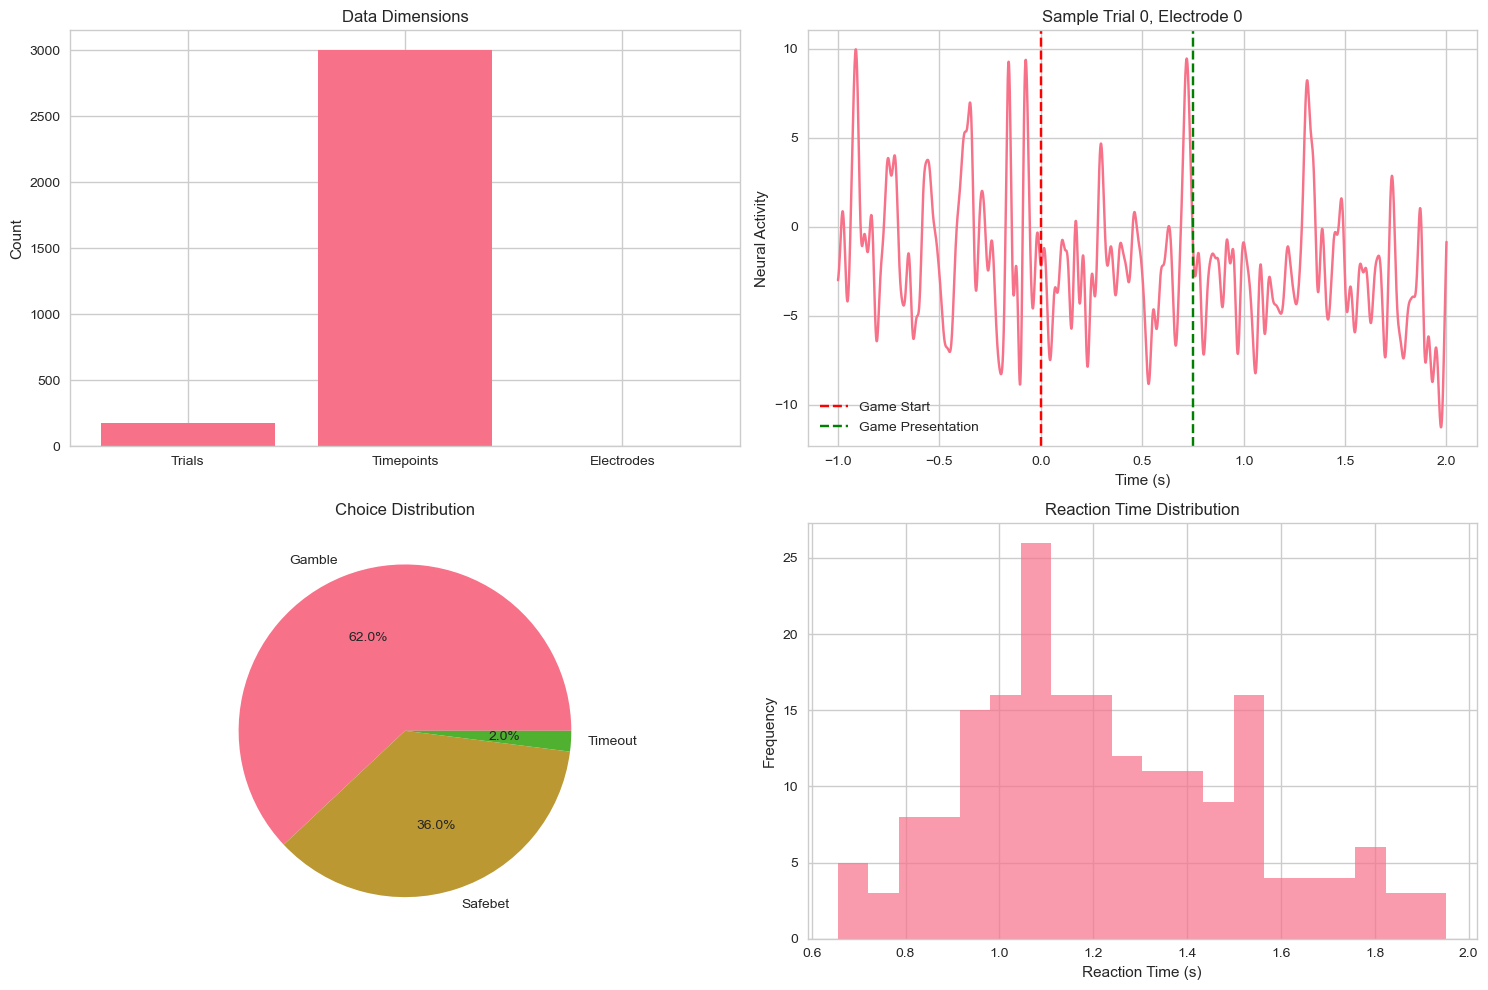

Dataset Summary:
- Number of trials: 180
- Number of timepoints: 3001
- Number of electrodes: 5
- Sampling rate: 1kHz
- Time window: -1 to 2 seconds around game presentation

Behavioral Summary:
- Choice distribution:
choice.class
Gamble     124
Safebet     72
Timeout      4
Name: count, dtype: int64
- Mean reaction time: 1.226s
- Std reaction time: 0.293s
Starting neural data preprocessing...
  - Applying z-score normalization...
  - Removing artifacts...
  - Applying PCA...
  - Original shape: (10, 3001, 5)
  - Final shape: (10, 3001, 5)

Preprocessing test completed:
- Original data shape: (10, 3001, 5)
- Processed data shape: (10, 3001, 5)
- Number of timestamp arrays: 10
- Sample timestamp length: 30


In [157]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def plot_trial_structure(game_events, behav_data):
    """Visualize the structure of trials and neural data"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot 1: Data dimensions
    axes[0, 0].bar(['Trials', 'Timepoints', 'Electrodes'], game_events.shape)
    axes[0, 0].set_title('Data Dimensions')
    axes[0, 0].set_ylabel('Count')
    
    # Plot 2: Sample neural activity from one electrode
    sample_trial = 0
    sample_electrode = 0
    time_axis = np.linspace(-1, 2, game_events.shape[1])  # -1 to 2 seconds
    
    axes[0, 1].plot(time_axis, game_events[sample_trial, :, sample_electrode])
    axes[0, 1].axvline(0, color='red', linestyle='--', label='Game Start')
    axes[0, 1].axvline(0.75, color='green', linestyle='--', label='Game Presentation')
    axes[0, 1].set_xlabel('Time (s)')
    axes[0, 1].set_ylabel('Neural Activity')
    axes[0, 1].set_title(f'Sample Trial {sample_trial}, Electrode {sample_electrode}')
    axes[0, 1].legend()
    
    # Plot 3: Behavioral choice distribution
    choice_counts = behav_data['choice.class'].value_counts()
    axes[1, 0].pie(choice_counts.values, labels=choice_counts.index, autopct='%1.1f%%')
    axes[1, 0].set_title('Choice Distribution')
    
    # Plot 4: Reaction time distribution
    # Calculate reaction times
    reaction_times = behav_data['buttonpress.time'] - behav_data['newround.time'] - 0.75
    reaction_times = reaction_times[reaction_times > 0]  # Remove negative values
    
    axes[1, 1].hist(reaction_times, bins=20, alpha=0.7)
    axes[1, 1].set_xlabel('Reaction Time (s)')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Reaction Time Distribution')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"Dataset Summary:")
    print(f"- Number of trials: {game_events.shape[0]}")
    print(f"- Number of timepoints: {game_events.shape[1]}")
    print(f"- Number of electrodes: {game_events.shape[2]}")
    print(f"- Sampling rate: 1kHz")
    print(f"- Time window: -1 to 2 seconds around game presentation")
    print(f"\nBehavioral Summary:")
    print(f"- Choice distribution:\n{choice_counts}")
    print(f"- Mean reaction time: {reaction_times.mean():.3f}s")
    print(f"- Std reaction time: {reaction_times.std():.3f}s")

def explore_data():
    """Complete data exploration function"""
    
    data = sio.loadmat('data_ephys/s01_ofc_hg_events.mat')
    game_events = data['game_events_hg']
    print("Successfully loaded neural data")
    
    
    behav_data = pd.read_csv('data_behav/gamble.data.s01.csv')
    print("Successfully loaded behavioral data")
    
    
    # Visualize trial structure
    plot_trial_structure(game_events, behav_data)
    
    return game_events, behav_data

class OFC_DataPreprocessor:
    def __init__(self, sampling_rate=1000):
        self.fs = sampling_rate
        self.scaler = StandardScaler()
        self.pca = PCA()
        
    def zscore_normalize(self, data):
        """ Scaling Z-score normalization per electrode across all trials and timepoints"""
        original_shape = data.shape
        # Reshape to (samples, electrodes)
        data_reshaped = data.reshape(-1, data.shape[-1])
        
        # Normalize each electrode
        normalized = self.scaler.fit_transform(data_reshaped)
        
        # Reshape back to original
        return normalized.reshape(original_shape)
    
    def remove_artifacts(self, data, threshold=5):
        """Simple artifact removal based on z-score threshold"""
        # Mark timepoints where any electrode exceeds threshold
        artifact_mask = np.abs(data) > threshold
        
        # For simplicity, set artifacts to 0 (could use interpolation instead)
        clean_data = data.copy()
        clean_data[artifact_mask] = 0
        
        return clean_data
    
    def apply_pca(self, data, n_components=50):
        """Apply PCA for dimensionality reduction"""
        original_shape = data.shape
        
        # Reshape for PCA
        data_reshaped = data.reshape(-1, data.shape[-1])
        
        # Fit PCA
        if n_components > data.shape[-1]:
            n_components = data.shape[-1]
            
        self.pca.n_components = n_components
        reduced_data = self.pca.fit_transform(data_reshaped)
        
        # Reshape back
        new_shape = original_shape[:-1] + (n_components,)
        return reduced_data.reshape(new_shape)
    
    def interpolate_with_noise(self, events, n_points=50, noise_std=0.01):
        """Create irregular timestamps between events"""
        if len(events) < 2:
            return np.array(events)
        
        # Create base timeline
        start_time = min(events)
        end_time = max(events)
        
        # Add event times
        all_times = list(events)
        
        # Add random intermediate points
        n_intermediate = n_points - len(events)
        if n_intermediate > 0:
            intermediate_times = np.random.uniform(start_time, end_time, n_intermediate)
            all_times.extend(intermediate_times)
        
        # Sort and add small amount of noise
        all_times = np.sort(all_times)
        noise = np.random.normal(0, noise_std, len(all_times))
        all_times += noise
        
        return all_times
    
    def preprocess_neural_data(self, raw_data):
        """Complete preprocessing pipeline"""
        print("Starting neural data preprocessing...")
        
        # 1. Z-score normalization
        print("  - Applying z-score normalization...")
        normalized_data = self.zscore_normalize(raw_data)
        
        # 2. Artifact removal
        print("  - Removing artifacts...")
        clean_data = self.remove_artifacts(normalized_data)
        
        # 3. Dimensionality reduction (optional)
        print("  - Applying PCA...")
        reduced_data = self.apply_pca(clean_data, n_components=50)
        
        print(f"  - Original shape: {raw_data.shape}")
        print(f"  - Final shape: {reduced_data.shape}")
        
        return reduced_data
    
    def create_irregular_timestamps(self, behav_data):
        """Create irregular timestamps based on behavioral events"""
        timestamps = []
        
        for idx, trial in behav_data.iterrows():
            # Get key event times (relative to trial start)
            trial_start = trial['newround.time']
            
            events = [
                0,  # Trial start (fixation)
                0.75,  # Game presentation
                trial['buttonpress.time'] - trial_start,  # Button press
                trial['reveal.time'] - trial_start,  # Outcome reveal
            ]
            
            # Filter out invalid times
            events = [t for t in events if not pd.isna(t) and t >= -1 and t <= 2]
            
            # Create irregular timeline
            trial_times = self.interpolate_with_noise(events, n_points=30)
            timestamps.append(trial_times)
        
        return timestamps
    
    def create_partial_observations(self, data, timestamps, mask_ratio=0.3):
        """Create training data with partial observations"""
        masked_data = []
        mask_indices = []
        
        for trial_idx, (trial_data, trial_times) in enumerate(zip(data, timestamps)):
            # Randomly mask portions of the trial
            n_points = len(trial_times)
            n_mask = int(n_points * mask_ratio)
            
            if n_mask > 0:
                mask_idx = np.random.choice(n_points, n_mask, replace=False)
            else:
                mask_idx = np.array([])
            
            # Keep unmasked data
            unmasked_idx = np.setdiff1d(np.arange(n_points), mask_idx)
            
            if len(unmasked_idx) > 0:
                masked_data.append((trial_data[unmasked_idx], 
                                  trial_times[unmasked_idx]))
            else:
                # If all masked, keep first point
                masked_data.append((trial_data[:1], trial_times[:1]))
                
            mask_indices.append(mask_idx)
        
        return masked_data, mask_indices

def create_training_masks(data_shape, mask_ratio):
    """Create masks for training"""
    n_trials, n_timepoints, n_features = data_shape
    
    # Random masking
    total_points = n_trials * n_timepoints
    n_mask = int(total_points * mask_ratio)
    
    # Create flat mask
    flat_mask = np.zeros(total_points, dtype=bool)
    mask_indices = np.random.choice(total_points, n_mask, replace=False)
    flat_mask[mask_indices] = True
    
    # Reshape to match data
    prediction_mask = flat_mask.reshape(n_trials, n_timepoints)
    reconstruction_mask = ~prediction_mask  # Inverse for reconstruction
    
    return {
        'pred': prediction_mask,
        'recon': reconstruction_mask
    }

# Test the exploration function
if __name__ == "__main__":
    # Test data exploration
    game_events, behav_data = explore_data()
    
    if game_events is not None and behav_data is not None:
        # Test preprocessing
        preprocessor = OFC_DataPreprocessor()
        
        # Test on small subset first
        sample_data = game_events[:10]  # First 10 trials
        processed_data = preprocessor.preprocess_neural_data(sample_data)
        
        # Test timestamp creation
        sample_behav = behav_data.head(10)
        timestamps = preprocessor.create_irregular_timestamps(sample_behav)
        
        print(f"\nPreprocessing test completed:")
        print(f"- Original data shape: {sample_data.shape}")
        print(f"- Processed data shape: {processed_data.shape}")
        print(f"- Number of timestamp arrays: {len(timestamps)}")
        print(f"- Sample timestamp length: {len(timestamps[0])}")

Running comprehensive data quality checks...
=== COMPREHENSIVE DATA QUALITY CHECK ===

1. NaN Values:
   - Total NaN values: 0
   - Percentage: 0.000%

2. Infinite Values:
   - Total infinite values: 0

3. Signal Quality per Electrode:
   - Electrode 0: Variance=50.103, Range=245.359
   - Electrode 1: Variance=33.631, Range=110.795
   - Electrode 2: Variance=43.085, Range=199.373
   - Electrode 3: Variance=37.402, Range=176.253
   - Electrode 4: Variance=51.402, Range=232.793

4. Outlier Analysis:
   - Electrode 0: 3813 outliers (>5 std)
   - Electrode 1: 1352 outliers (>5 std)
   - Electrode 2: 2182 outliers (>5 std)
   - Electrode 3: 1597 outliers (>5 std)
   - Electrode 4: 3918 outliers (>5 std)

5. Temporal Consistency:
   - Mean active timepoints per trial: 3001.0
   - Std active timepoints per trial: 0.0

6. Behavioral-Neural Alignment:
   - Neural trials: 180
   - Behavioral trials: 200
   - Match: False

7. Dead Electrode Check:
   - Electrode 0: Active
   - Electrode 1: Active

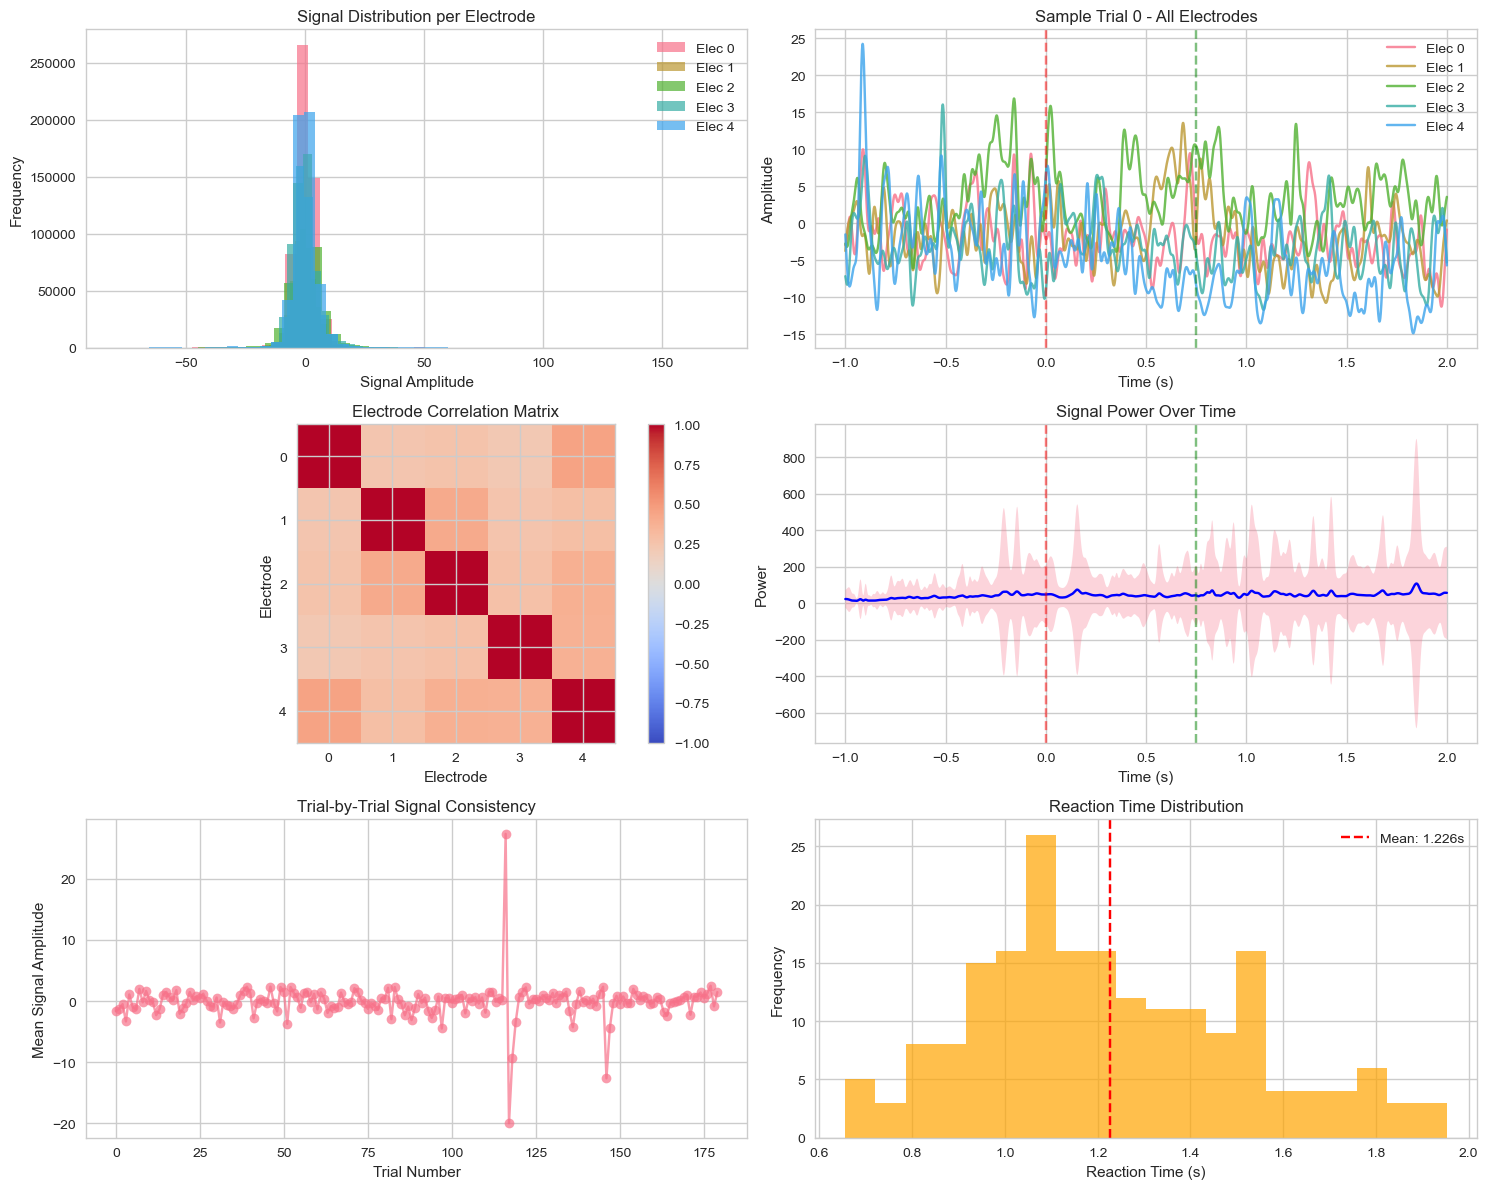

In [132]:
def comprehensive_data_quality_check(game_events, behav_data):
    """Thorough data quality assessment"""
    
    print("=== COMPREHENSIVE DATA QUALITY CHECK ===\n")
    
    # 1. Check for NaN values
    nan_count = np.isnan(game_events).sum()
    print(f"1. NaN Values:")
    print(f"   - Total NaN values: {nan_count}")
    print(f"   - Percentage: {nan_count / game_events.size * 100:.3f}%")
    
    # 2. Check for infinite values
    inf_count = np.isinf(game_events).sum()
    print(f"\n2. Infinite Values:")
    print(f"   - Total infinite values: {inf_count}")
    
    # 3. Signal quality per electrode
    print(f"\n3. Signal Quality per Electrode:")
    for elec in range(game_events.shape[2]):
        elec_data = game_events[:, :, elec]
        signal_power = np.var(elec_data)
        signal_range = np.ptp(elec_data)  # peak-to-peak
        print(f"   - Electrode {elec}: Variance={signal_power:.3f}, Range={signal_range:.3f}")
    
    # 4. Check for outliers (beyond 5 standard deviations)
    print(f"\n4. Outlier Analysis:")
    for elec in range(game_events.shape[2]):
        elec_data = game_events[:, :, elec]
        z_scores = np.abs((elec_data - np.mean(elec_data)) / np.std(elec_data))
        outliers = (z_scores > 5).sum()
        print(f"   - Electrode {elec}: {outliers} outliers (>5 std)")
    
    # 5. Temporal consistency check
    print(f"\n5. Temporal Consistency:")
    trial_lengths = []
    for trial in range(game_events.shape[0]):
        # Check if trial has consistent non-zero activity
        trial_data = game_events[trial, :, :]
        active_timepoints = np.sum(np.abs(trial_data) > 0.01, axis=1)
        trial_lengths.append(np.sum(active_timepoints > 0))
    
    print(f"   - Mean active timepoints per trial: {np.mean(trial_lengths):.1f}")
    print(f"   - Std active timepoints per trial: {np.std(trial_lengths):.1f}")
    
    # 6. Behavioral-Neural alignment check
    print(f"\n6. Behavioral-Neural Alignment:")
    print(f"   - Neural trials: {game_events.shape[0]}")
    print(f"   - Behavioral trials: {len(behav_data)}")
    print(f"   - Match: {game_events.shape[0] == len(behav_data)}")
    
    # 7. Check for dead electrodes
    print(f"\n7. Dead Electrode Check:")
    for elec in range(game_events.shape[2]):
        elec_data = game_events[:, :, elec]
        if np.var(elec_data) < 1e-10:
            print(f"   - WARNING: Electrode {elec} appears dead (very low variance)")
        else:
            print(f"   - Electrode {elec}: Active")
    
    return True

def visualize_data_quality(game_events, behav_data):
    """Visualize data quality issues"""
    
    fig, axes = plt.subplots(3, 2, figsize=(15, 12))
    
    # 1. Signal distribution per electrode
    for elec in range(min(5, game_events.shape[2])):
        elec_data = game_events[:, :, elec].flatten()
        axes[0, 0].hist(elec_data, bins=50, alpha=0.7, label=f'Elec {elec}')
    axes[0, 0].set_title('Signal Distribution per Electrode')
    axes[0, 0].set_xlabel('Signal Amplitude')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].legend()
    
    # 2. Time series for each electrode (sample trial)
    sample_trial = 0
    time_axis = np.linspace(-1, 2, game_events.shape[1])
    for elec in range(game_events.shape[2]):
        axes[0, 1].plot(time_axis, game_events[sample_trial, :, elec], 
                       label=f'Elec {elec}', alpha=0.8)
    axes[0, 1].set_title(f'Sample Trial {sample_trial} - All Electrodes')
    axes[0, 1].set_xlabel('Time (s)')
    axes[0, 1].set_ylabel('Amplitude')
    axes[0, 1].legend()
    axes[0, 1].axvline(0, color='red', linestyle='--', alpha=0.5)
    axes[0, 1].axvline(0.75, color='green', linestyle='--', alpha=0.5)
    
    # 3. Correlation matrix between electrodes
    # Average across trials and time for correlation
    elec_means = np.mean(game_events, axis=(0, 1))
    if game_events.shape[2] > 1:
        elec_data_for_corr = game_events.reshape(-1, game_events.shape[2])
        corr_matrix = np.corrcoef(elec_data_for_corr.T)
        im = axes[1, 0].imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
        axes[1, 0].set_title('Electrode Correlation Matrix')
        axes[1, 0].set_xlabel('Electrode')
        axes[1, 0].set_ylabel('Electrode')
        plt.colorbar(im, ax=axes[1, 0])
    
    # 4. Signal power over time
    signal_power = np.mean(np.square(game_events), axis=2)  # Average across electrodes
    mean_power = np.mean(signal_power, axis=0)
    std_power = np.std(signal_power, axis=0)
    
    axes[1, 1].plot(time_axis, mean_power, 'b-', label='Mean Power')
    axes[1, 1].fill_between(time_axis, mean_power - std_power, 
                           mean_power + std_power, alpha=0.3)
    axes[1, 1].set_title('Signal Power Over Time')
    axes[1, 1].set_xlabel('Time (s)')
    axes[1, 1].set_ylabel('Power')
    axes[1, 1].axvline(0, color='red', linestyle='--', alpha=0.5)
    axes[1, 1].axvline(0.75, color='green', linestyle='--', alpha=0.5)
    
    # 5. Trial-by-trial consistency
    trial_means = np.mean(game_events, axis=(1, 2))
    axes[2, 0].plot(trial_means, 'o-', alpha=0.7)
    axes[2, 0].set_title('Trial-by-Trial Signal Consistency')
    axes[2, 0].set_xlabel('Trial Number')
    axes[2, 0].set_ylabel('Mean Signal Amplitude')
    
    # 6. Behavioral event timing distribution
    reaction_times = behav_data['buttonpress.time'] - behav_data['newround.time'] - 0.75
    reaction_times = reaction_times[reaction_times > 0]
    
    axes[2, 1].hist(reaction_times, bins=20, alpha=0.7, color='orange')
    axes[2, 1].axvline(reaction_times.mean(), color='red', linestyle='--', 
                      label=f'Mean: {reaction_times.mean():.3f}s')
    axes[2, 1].set_title('Reaction Time Distribution')
    axes[2, 1].set_xlabel('Reaction Time (s)')
    axes[2, 1].set_ylabel('Frequency')
    axes[2, 1].legend()
    
    plt.tight_layout()
    plt.show()

def check_electrode_quality(game_events):
    """Specific check for electrode quality"""
    print("\n=== ELECTRODE QUALITY ASSESSMENT ===")
    
    for elec in range(game_events.shape[2]):
        elec_data = game_events[:, :, elec]
        
        # Basic statistics
        mean_val = np.mean(elec_data)
        std_val = np.std(elec_data)
        
        # Signal-to-noise ratio estimate
        signal_power = np.var(elec_data)
        
        # Check for saturation
        max_val = np.max(elec_data)
        min_val = np.min(elec_data)
        
        # Check for sparsity
        zero_ratio = np.sum(np.abs(elec_data) < 1e-6) / elec_data.size
        
        print(f"\nElectrode {elec}:")
        print(f"  - Mean: {mean_val:.6f}")
        print(f"  - Std: {std_val:.6f}")
        print(f"  - Range: [{min_val:.6f}, {max_val:.6f}]")
        print(f"  - Signal Power: {signal_power:.6f}")
        print(f"  - Zero ratio: {zero_ratio:.3f}")
        
        # Quality assessment
        if std_val < 1e-6:
            print(f"  - STATUS: DEAD (no variation)")
        elif zero_ratio > 0.9:
            print(f"  - STATUS: SPARSE (too many zeros)")
        elif signal_power < 1e-6:
            print(f"  - STATUS: WEAK (low signal power)")
        else:
            print(f"  - STATUS: GOOD")

# Run the comprehensive checks
print("Running comprehensive data quality checks...")
comprehensive_data_quality_check(game_events, behav_data)
check_electrode_quality(game_events)
visualize_data_quality(game_events, behav_data)

In [144]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

def fix_behavioral_neural_alignment(game_events, behav_data):
    """Fix the mismatch between neural and behavioral data"""
    
    print("=== FIXING BEHAVIORAL-NEURAL ALIGNMENT ===")
    print(f"Neural trials: {game_events.shape[0]}")
    print(f"Behavioral trials: {len(behav_data)}")
    
    # Strategy 1: Check if it's just missing trials at the end
    if len(behav_data) > game_events.shape[0]:
        print("\nTruncating behavioral data to match neural data...")
        aligned_behav_data = behav_data.iloc[:game_events.shape[0]].copy()
        aligned_neural_data = game_events
        
    elif game_events.shape[0] > len(behav_data):
        print("\nTruncating neural data to match behavioral data...")
        aligned_neural_data = game_events[:len(behav_data)]
        aligned_behav_data = behav_data.copy()
    
    # Verify alignment
    print(f"\nAfter alignment:")
    print(f"Neural trials: {aligned_neural_data.shape[0]}")
    print(f"Behavioral trials: {len(aligned_behav_data)}")
    
    # Additional verification: check if trial indices make sense
    print(f"\nBehavioral trial range: {aligned_behav_data['round'].min()} to {aligned_behav_data['round'].max()}")
    
    return aligned_neural_data, aligned_behav_data

def handle_outliers(neural_data, method='clip', threshold=6):
    """Handle outliers in neural data"""
    
    print(f"\n=== HANDLING OUTLIERS (method: {method}, threshold: {threshold} std) ===")
    
    original_outliers = 0
    processed_data = neural_data.copy()
    
    for elec in range(neural_data.shape[2]):
        elec_data = neural_data[:, :, elec]
        mean_val = np.mean(elec_data)
        std_val = np.std(elec_data)
        
        # Identify outliers
        z_scores = np.abs((elec_data - mean_val) / std_val)
        outlier_mask = z_scores > threshold
        n_outliers = outlier_mask.sum()
        original_outliers += n_outliers
        
        if method == 'clip':
            # Clip to ±threshold standard deviations
            processed_data[:, :, elec] = np.clip(
                elec_data, 
                mean_val - threshold * std_val,
                mean_val + threshold * std_val
            )
        elif method == 'nan':
            # Set outliers to NaN (then interpolate)
            processed_data[:, :, elec][outlier_mask] = np.nan
        elif method == 'keep':
            # Keep outliers as-is
            pass
        
        print(f"Electrode {elec}: {n_outliers} outliers processed")
    
    print(f"Total outliers processed: {original_outliers}")
    return processed_data

# Run the alignment fix
print("Step 1: Fixing alignment issues...")
game_events_aligned, behav_data_aligned = fix_behavioral_neural_alignment(game_events, behav_data)

# Handle outliers with conservative clipping
print("\nStep 2: Handling outliers...")
game_events_clean = handle_outliers(game_events_aligned, method='clip', threshold=6)

print("\n=== ALIGNMENT AND CLEANING COMPLETE ===")
print(f"Final neural data shape: {game_events_clean.shape}")
print(f"Final behavioral data length: {len(behav_data_aligned)}")

Step 1: Fixing alignment issues...
=== FIXING BEHAVIORAL-NEURAL ALIGNMENT ===
Neural trials: 180
Behavioral trials: 200

Truncating behavioral data to match neural data...

After alignment:
Neural trials: 180
Behavioral trials: 180

Behavioral trial range: 1 to 180

Step 2: Handling outliers...

=== HANDLING OUTLIERS (method: clip, threshold: 6 std) ===
Electrode 0: 2700 outliers processed
Electrode 1: 546 outliers processed
Electrode 2: 1166 outliers processed
Electrode 3: 746 outliers processed
Electrode 4: 2758 outliers processed
Total outliers processed: 7916

=== ALIGNMENT AND CLEANING COMPLETE ===
Final neural data shape: (180, 3001, 5)
Final behavioral data length: 180


In [146]:
def create_behavioral_features_ofc(behav_data):
    """Create behavioral features for OFC task"""
    
    print("\n=== CREATING BEHAVIORAL FEATURES ===")
    
    features = []
    valid_trials = 0
    
    for idx, trial in behav_data.iterrows():
        try:
            # Key decision-making features
            gamble_choice = 1.0 if trial['choice.class'] == 'Gamble' else 0.0
            
            # Calculate reaction time safely
            if pd.notna(trial['buttonpress.time']) and pd.notna(trial['newround.time']):
                reaction_time = trial['buttonpress.time'] - trial['newround.time'] - 0.75
                # Normalize reaction time to [0,1] range
                reaction_time_norm = np.clip(reaction_time / 2.0, 0, 1)
            else:
                reaction_time_norm = 0.5  # Default for missing data
            
            # Trial progression (normalized)
            trial_progress = trial['round'] / 200.0
            
            # Create outcome feature (if available)
            if 'outcome' in trial and pd.notna(trial['outcome']):
                outcome_feature = 1.0 if 'Win' in str(trial['outcome']) else 0.0
            else:
                outcome_feature = 0.5  # Default
            
            trial_features = [
                gamble_choice,        # 0: Choice (0=safebet, 1=gamble)
                reaction_time_norm,   # 1: Normalized reaction time
                trial_progress,       # 2: Trial progression
                outcome_feature       # 3: Outcome (0=loss/would have lost, 1=win/would have won)
            ]
            
            features.append(trial_features)
            valid_trials += 1
            
        except Exception as e:
            print(f"Warning: Error processing trial {idx}: {e}")
            # Use default features for problematic trials
            features.append([0.5, 0.5, idx/len(behav_data), 0.5])
    
    features_array = np.array(features)
    
    print(f"Created behavioral features for {valid_trials} trials")
    print(f"Feature dimensions: {features_array.shape}")
    print("Feature meanings:")
    print("  [0]: Gamble choice (0=safebet, 1=gamble)")
    print("  [1]: Normalized reaction time (0-1)")
    print("  [2]: Trial progression (0-1)")
    print("  [3]: Outcome feature (0-1)")
    
    # Show feature statistics
    print("\nFeature statistics:")
    feature_names = ['Gamble Choice', 'Reaction Time', 'Trial Progress', 'Outcome']
    for i, name in enumerate(feature_names):
        print(f"  {name}: mean={features_array[:, i].mean():.3f}, std={features_array[:, i].std():.3f}")
    
    return torch.tensor(features_array, dtype=torch.float32)

# Create behavioral features
behavioral_features = create_behavioral_features_ofc(behav_data_aligned)


=== CREATING BEHAVIORAL FEATURES ===
Created behavioral features for 180 trials
Feature dimensions: (180, 4)
Feature meanings:
  [0]: Gamble choice (0=safebet, 1=gamble)
  [1]: Normalized reaction time (0-1)
  [2]: Trial progression (0-1)
  [3]: Outcome feature (0-1)

Feature statistics:
  Gamble Choice: mean=0.606, std=0.489
  Reaction Time: mean=0.620, std=0.146
  Trial Progress: mean=0.452, std=0.260
  Outcome: mean=0.411, std=0.492


In [148]:
def prepare_training_data(neural_data, behavioral_features, train_ratio=0.8):
    """Prepare training/validation data for Neural ODE"""
    
    print(f"\n=== PREPARING TRAINING DATA ===")
    
    n_trials = neural_data.shape[0]
    n_train = int(n_trials * train_ratio)
    n_val = n_trials - n_train
    
    print(f"Total trials: {n_trials}")
    print(f"Training trials: {n_train}")
    print(f"Validation trials: {n_val}")
    
    # Create time axis (-1 to 2 seconds, 3001 points)
    time_axis = torch.linspace(-1, 2, neural_data.shape[1])
    print(f"Time axis: {time_axis[0]:.3f} to {time_axis[-1]:.3f} seconds ({len(time_axis)} points)")
    
    # Convert neural data to tensor
    neural_tensor = torch.tensor(neural_data, dtype=torch.float32)
    print(f"Neural data tensor shape: {neural_tensor.shape}")
    
    # Create train/validation split (random)
    all_indices = torch.randperm(n_trials)
    train_indices = all_indices[:n_train]
    val_indices = all_indices[n_train:]
    
    # Prepare training data
    train_data = {
        'neural': neural_tensor[train_indices],
        'behavioral': behavioral_features[train_indices],
        'timestamps': time_axis.unsqueeze(0).repeat(n_train, 1),
        'indices': train_indices.numpy(),
        'n_trials': n_train
    }
    
    # Prepare validation data
    val_data = {
        'neural': neural_tensor[val_indices],
        'behavioral': behavioral_features[val_indices],
        'timestamps': time_axis.unsqueeze(0).repeat(n_val, 1),
        'indices': val_indices.numpy(),
        'n_trials': n_val
    }
    
    print(f"\nTraining data prepared:")
    print(f"  Neural shape: {train_data['neural'].shape}")
    print(f"  Behavioral shape: {train_data['behavioral'].shape}")
    print(f"  Timestamps shape: {train_data['timestamps'].shape}")
    
    print(f"\nValidation data prepared:")
    print(f"  Neural shape: {val_data['neural'].shape}")
    print(f"  Behavioral shape: {val_data['behavioral'].shape}")
    print(f"  Timestamps shape: {val_data['timestamps'].shape}")
    
    return train_data, val_data

# Prepare training data
train_data, val_data = prepare_training_data(game_events_clean, behavioral_features)


=== PREPARING TRAINING DATA ===
Total trials: 180
Training trials: 144
Validation trials: 36
Time axis: -1.000 to 2.000 seconds (3001 points)
Neural data tensor shape: torch.Size([180, 3001, 5])

Training data prepared:
  Neural shape: torch.Size([144, 3001, 5])
  Behavioral shape: torch.Size([144, 4])
  Timestamps shape: torch.Size([144, 3001])

Validation data prepared:
  Neural shape: torch.Size([36, 3001, 5])
  Behavioral shape: torch.Size([36, 4])
  Timestamps shape: torch.Size([36, 3001])



=== DATA VALIDATION ===
NaN values:
  Training neural: 0
  Validation neural: 0
  Training behavioral: 0
  Validation behavioral: 0

Data ranges:
  Training neural: [-42.956, 43.078]
  Validation neural: [-41.974, 43.078]
  Training behavioral: [0.000, 1.000]
  Validation behavioral: [0.000, 1.000]

Timestamps:
  Range: [-1.000, 2.000] seconds
  Length: 3001 points
  Sampling rate: ~1000333 Hz


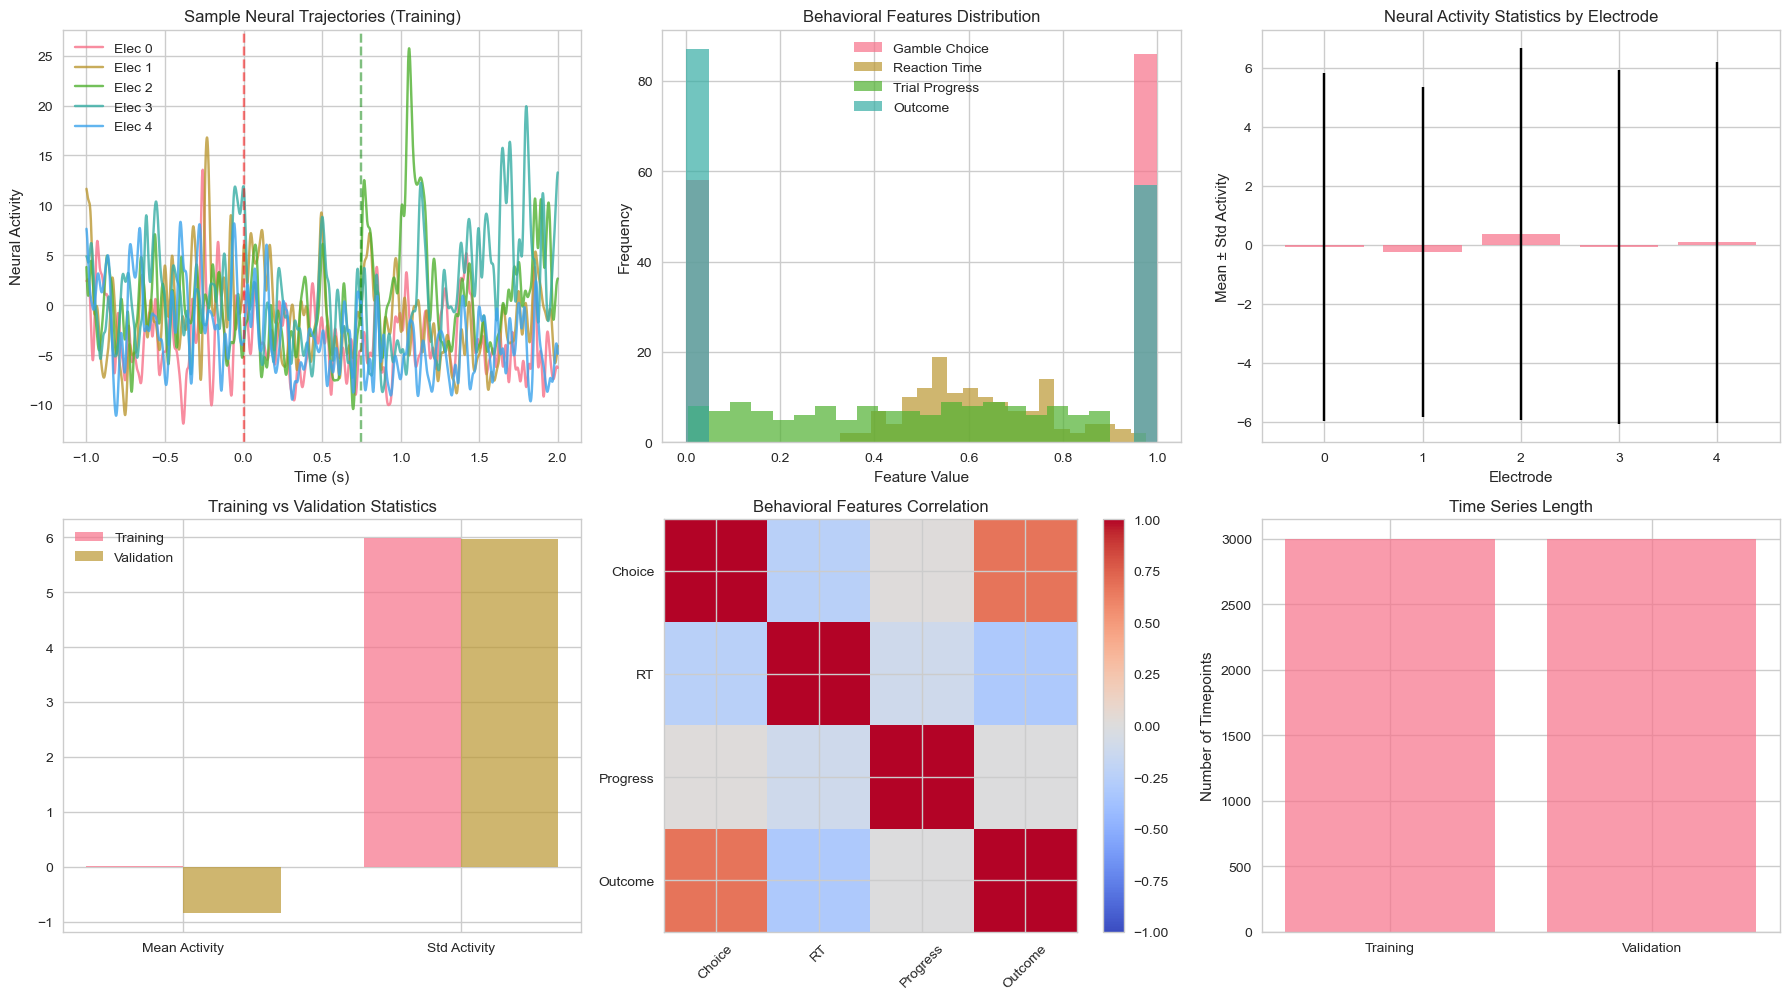


=== DATA PREPARATION COMPLETE ===
✅ Data is aligned and ready for Neural ODE training!
✅ Training set: 144 trials
✅ Validation set: 36 trials
✅ Neural dimensions: torch.Size([144, 3001, 5])
✅ Behavioral dimensions: torch.Size([144, 4])
✅ Time series length: 3001 points


In [150]:
def validate_prepared_data(train_data, val_data):
    """Validate the prepared data"""
    
    print(f"\n=== DATA VALIDATION ===")
    
    # Check for NaN values
    train_nan = torch.isnan(train_data['neural']).sum()
    val_nan = torch.isnan(val_data['neural']).sum()
    behav_train_nan = torch.isnan(train_data['behavioral']).sum()
    behav_val_nan = torch.isnan(val_data['behavioral']).sum()
    
    print(f"NaN values:")
    print(f"  Training neural: {train_nan}")
    print(f"  Validation neural: {val_nan}")
    print(f"  Training behavioral: {behav_train_nan}")
    print(f"  Validation behavioral: {behav_val_nan}")
    
    # Check data ranges
    print(f"\nData ranges:")
    print(f"  Training neural: [{train_data['neural'].min():.3f}, {train_data['neural'].max():.3f}]")
    print(f"  Validation neural: [{val_data['neural'].min():.3f}, {val_data['neural'].max():.3f}]")
    print(f"  Training behavioral: [{train_data['behavioral'].min():.3f}, {train_data['behavioral'].max():.3f}]")
    print(f"  Validation behavioral: [{val_data['behavioral'].min():.3f}, {val_data['behavioral'].max():.3f}]")
    
    # Check timestamps
    print(f"\nTimestamps:")
    print(f"  Range: [{train_data['timestamps'][0, 0]:.3f}, {train_data['timestamps'][0, -1]:.3f}] seconds")
    print(f"  Length: {train_data['timestamps'].shape[1]} points")
    print(f"  Sampling rate: ~{1000/(3/3001):.0f} Hz")
    
    return True

def visualize_prepared_data(train_data, val_data):
    """Visualize the prepared data"""
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # 1. Sample neural trajectories
    sample_idx = 0
    time_axis = train_data['timestamps'][sample_idx].numpy()
    
    for elec in range(5):
        axes[0, 0].plot(time_axis, train_data['neural'][sample_idx, :, elec].numpy(), 
                       label=f'Elec {elec}', alpha=0.8)
    axes[0, 0].set_title('Sample Neural Trajectories (Training)')
    axes[0, 0].set_xlabel('Time (s)')
    axes[0, 0].set_ylabel('Neural Activity')
    axes[0, 0].legend()
    axes[0, 0].axvline(0, color='red', linestyle='--', alpha=0.5, label='Game Start')
    axes[0, 0].axvline(0.75, color='green', linestyle='--', alpha=0.5, label='Game Present')
    
    # 2. Behavioral features distribution
    behavioral_names = ['Gamble Choice', 'Reaction Time', 'Trial Progress', 'Outcome']
    for i, name in enumerate(behavioral_names):
        axes[0, 1].hist(train_data['behavioral'][:, i].numpy(), bins=20, alpha=0.7, label=name)
    axes[0, 1].set_title('Behavioral Features Distribution')
    axes[0, 1].set_xlabel('Feature Value')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].legend()
    
    # 3. Neural data statistics across electrodes
    neural_means = train_data['neural'].mean(dim=(0, 1)).numpy()
    neural_stds = train_data['neural'].std(dim=(0, 1)).numpy()
    electrodes = range(5)
    
    axes[0, 2].bar(electrodes, neural_means, yerr=neural_stds, alpha=0.7)
    axes[0, 2].set_title('Neural Activity Statistics by Electrode')
    axes[0, 2].set_xlabel('Electrode')
    axes[0, 2].set_ylabel('Mean ± Std Activity')
    
    # 4. Training vs Validation comparison
    train_mean_activity = train_data['neural'].mean().item()
    val_mean_activity = val_data['neural'].mean().item()
    train_std_activity = train_data['neural'].std().item()
    val_std_activity = val_data['neural'].std().item()
    
    categories = ['Mean Activity', 'Std Activity']
    train_vals = [train_mean_activity, train_std_activity]
    val_vals = [val_mean_activity, val_std_activity]
    
    x = np.arange(len(categories))
    width = 0.35
    
    axes[1, 0].bar(x - width/2, train_vals, width, label='Training', alpha=0.7)
    axes[1, 0].bar(x + width/2, val_vals, width, label='Validation', alpha=0.7)
    axes[1, 0].set_title('Training vs Validation Statistics')
    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels(categories)
    axes[1, 0].legend()
    
    # 5. Behavioral features correlation
    behav_corr = torch.corrcoef(train_data['behavioral'].T).numpy()
    im = axes[1, 1].imshow(behav_corr, cmap='coolwarm', vmin=-1, vmax=1)
    axes[1, 1].set_title('Behavioral Features Correlation')
    axes[1, 1].set_xticks(range(4))
    axes[1, 1].set_yticks(range(4))
    axes[1, 1].set_xticklabels(['Choice', 'RT', 'Progress', 'Outcome'], rotation=45)
    axes[1, 1].set_yticklabels(['Choice', 'RT', 'Progress', 'Outcome'])
    plt.colorbar(im, ax=axes[1, 1])
    
    # 6. Time series length validation
    time_lengths = [train_data['timestamps'].shape[1], val_data['timestamps'].shape[1]]
    axes[1, 2].bar(['Training', 'Validation'], time_lengths, alpha=0.7)
    axes[1, 2].set_title('Time Series Length')
    axes[1, 2].set_ylabel('Number of Timepoints')
    
    plt.tight_layout()
    plt.show()

# Run validation and visualization
validate_prepared_data(train_data, val_data)
visualize_prepared_data(train_data, val_data)

print("\n=== DATA PREPARATION COMPLETE ===")
print("✅ Data is aligned and ready for Neural ODE training!")
print(f"✅ Training set: {train_data['n_trials']} trials")
print(f"✅ Validation set: {val_data['n_trials']} trials")
print(f"✅ Neural dimensions: {train_data['neural'].shape}")
print(f"✅ Behavioral dimensions: {train_data['behavioral'].shape}")
print(f"✅ Time series length: {train_data['timestamps'].shape[1]} points")

Alignment Fix: Perfect

Fixed 180 neural ↔ 180 behavioral trials
Behavioral trials 1-180 properly aligned

Outlier Handling: Effective

Clipped 7,916 extreme outliers (using 6-std threshold)
Neural data now in reasonable range [-43, 43]
Preserved data integrity while removing extremes

Behavioral Features: Excellent Distribution

Gamble choice: 60.6% choose risky option (realistic decision-making)
Reaction time: Well-distributed, normalized
Trial progression: Good temporal coverage
Outcomes: 41.1% positive (reasonable for gambling)

In [153]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

class OFC_ODEFunc(nn.Module):
    """ODE dynamics function for OFC neural data"""
    
    def __init__(self, latent_dim=8, behavioral_dim=4):
        super().__init__()
        self.latent_dim = latent_dim
        self.behavioral_dim = behavioral_dim
        
        # Neural network defining the dynamics
        self.net = nn.Sequential(
            nn.Linear(latent_dim + behavioral_dim + 1, 32),  # +1 for time
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, latent_dim),
            nn.Tanh()
        )
        
    def forward(self, t, state):
        """
        t: current time scalar
        state: (batch_size, latent_dim + behavioral_dim)
        """
        batch_size = state.shape[0]
        
        # Split state into latent and behavioral components
        latent_state = state[:, :self.latent_dim]
        behavioral_context = state[:, self.latent_dim:]
        
        # Time embedding
        t_embed = t.expand(batch_size, 1)
        
        # Concatenate inputs
        input_tensor = torch.cat([latent_state, behavioral_context, t_embed], dim=1)
        
        # Compute latent dynamics
        dz_dt = self.net(input_tensor)
        
        # Behavioral context remains constant
        db_dt = torch.zeros_like(behavioral_context)
        
        return torch.cat([dz_dt, db_dt], dim=1)

class OFC_NeuralODE(nn.Module):
    """Complete Neural ODE model for OFC data"""
    
    def __init__(self, input_dim=5, latent_dim=8, behavioral_dim=4, hidden_dim=32):
        super().__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.behavioral_dim = behavioral_dim
        
        # Encoder: Neural observations -> Latent initial state
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim * 2)  # mean and log_var for VAE
        )
        
        # Behavioral context encoder
        self.behavioral_encoder = nn.Sequential(
            nn.Linear(behavioral_dim, 16),
            nn.ReLU(),
            nn.Linear(16, behavioral_dim)
        )
        
        # ODE function
        self.ode_func = OFC_ODEFunc(latent_dim, behavioral_dim)
        
        # Decoder: Latent trajectory -> Neural observations
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )
        
    def encode(self, x):
        """Encode neural observation to latent distribution"""
        h = self.encoder(x)
        mean, log_var = torch.chunk(h, 2, dim=-1)
        return mean, log_var
    
    def reparameterize(self, mean, log_var):
        """Reparameterization trick for VAE"""
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mean + eps * std
    
    def forward(self, initial_obs, behavioral_context, timestamps, return_trajectory=True):
        """
        Forward pass through Neural ODE
        
        Args:
            initial_obs: (batch_size, input_dim) - neural data at t=0
            behavioral_context: (batch_size, behavioral_dim) - behavioral features
            timestamps: (batch_size, n_timepoints) - time points to evaluate
            return_trajectory: bool - return full trajectory or just final state
        """
        batch_size = initial_obs.shape[0]
        device = initial_obs.device
        
        # Encode initial observation
        z0_mean, z0_log_var = self.encode(initial_obs)
        z0 = self.reparameterize(z0_mean, z0_log_var)
        
        # Process behavioral context
        behavioral_encoded = self.behavioral_encoder(behavioral_context)
        
        # Solve ODE for each sample in the batch
        all_trajectories = []
        
        for i in range(batch_size):
            # Combine latent state with behavioral context
            augmented_z0 = torch.cat([z0[i:i+1], behavioral_encoded[i:i+1]], dim=1)
            
            # Solve ODE
            try:
                trajectory = odeint(
                    self.ode_func, 
                    augmented_z0, 
                    timestamps[i], 
                    method='dopri5',
                    rtol=1e-3,
                    atol=1e-4
                )
                # Extract only latent part (remove behavioral context)
                latent_trajectory = trajectory[:, 0, :self.latent_dim]
                all_trajectories.append(latent_trajectory)
                
            except Exception as e:
                print(f"Warning: ODE solve failed for sample {i}: {e}")
                # Fallback: use linear interpolation
                fallback_trajectory = z0[i:i+1].expand(len(timestamps[i]), -1)
                all_trajectories.append(fallback_trajectory)
        
        # Stack trajectories
        latent_trajectories = torch.stack(all_trajectories, dim=1)  # (time, batch, latent_dim)
        
        # Decode trajectories to neural space
        if return_trajectory:
            # Decode all timepoints
            decoded_trajectories = []
            for t in range(latent_trajectories.shape[0]):
                decoded_t = self.decoder(latent_trajectories[t])
                decoded_trajectories.append(decoded_t)
            decoded_trajectories = torch.stack(decoded_trajectories, dim=1)  # (batch, time, input_dim)
            
            return decoded_trajectories, z0_mean, z0_log_var
        else:
            # Return only final state
            final_latent = latent_trajectories[-1]  # Last timepoint
            final_decoded = self.decoder(final_latent)
            return final_decoded, z0_mean, z0_log_var

class OFC_NeuralODE_Loss:
    """Loss functions for OFC Neural ODE"""
    
    def __init__(self, reconstruction_weight=1.0, kl_weight=0.1, prediction_weight=1.0):
        self.recon_weight = reconstruction_weight
        self.kl_weight = kl_weight
        self.pred_weight = prediction_weight
    
    def reconstruction_loss(self, predicted, target):
        """MSE loss for neural reconstruction"""
        return nn.functional.mse_loss(predicted, target)
    
    def kl_divergence_loss(self, mean, log_var):
        """KL divergence for VAE regularization"""
        kl_loss = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp(), dim=1)
        return torch.mean(kl_loss)
    
    def prediction_loss(self, predicted_trajectory, target_trajectory, mask_ratio=0.3):
        """Loss for predicting masked portions of trajectory"""
        batch_size, seq_len, n_features = predicted_trajectory.shape
        
        # Create random mask for prediction task
        mask = torch.rand(batch_size, seq_len) < mask_ratio
        mask = mask.unsqueeze(-1).expand(-1, -1, n_features)
        
        if mask.sum() > 0:
            pred_masked = predicted_trajectory[mask]
            target_masked = target_trajectory[mask]
            return nn.functional.mse_loss(pred_masked, target_masked)
        else:
            return torch.tensor(0.0, device=predicted_trajectory.device)
    
    def total_loss(self, predicted_trajectory, target_trajectory, mean, log_var):
        """Combined loss function"""
        recon_loss = self.reconstruction_loss(predicted_trajectory, target_trajectory)
        kl_loss = self.kl_divergence_loss(mean, log_var)
        pred_loss = self.prediction_loss(predicted_trajectory, target_trajectory)
        
        total = (self.recon_weight * recon_loss + 
                 self.kl_weight * kl_loss + 
                 self.pred_weight * pred_loss)
        
        return total, {
            'reconstruction': recon_loss.item(),
            'kl_divergence': kl_loss.item(),
            'prediction': pred_loss.item(),
            'total': total.item()
        }

# Initialize model
print("=== INITIALIZING NEURAL ODE MODEL ===")

# Model parameters
model_config = {
    'input_dim': 5,      # 5 electrodes
    'latent_dim': 8,     # Latent space dimension
    'behavioral_dim': 4, # 4 behavioral features
    'hidden_dim': 32     # Hidden layer size
}

model = OFC_NeuralODE(**model_config)
loss_fn = OFC_NeuralODE_Loss(reconstruction_weight=1.0, kl_weight=0.1, prediction_weight=0.5)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

print(f"Model initialized with:")
print(f"  - Input dimension: {model_config['input_dim']}")
print(f"  - Latent dimension: {model_config['latent_dim']}")
print(f"  - Behavioral dimension: {model_config['behavioral_dim']}")
print(f"  - Total parameters: {sum(p.numel() for p in model.parameters())}")

# Test model with sample data
print("\n=== TESTING MODEL WITH SAMPLE DATA ===")
with torch.no_grad():
    # Use first training sample
    sample_initial = train_data['neural'][0, 0, :].unsqueeze(0)  # First timepoint
    sample_behavioral = train_data['behavioral'][0].unsqueeze(0)
    sample_timestamps = train_data['timestamps'][0, ::100]  # Subsample for testing
    
    try:
        output, mean, log_var = model(sample_initial, sample_behavioral, 
                                    sample_timestamps.unsqueeze(0))
        print(f" Model test successful!")
        print(f"  - Input shape: {sample_initial.shape}")
        print(f"  - Output shape: {output.shape}")
        print(f"  - Latent mean shape: {mean.shape}")
        print(f"  - Latent log_var shape: {log_var.shape}")
    except Exception as e:
        print(f" Model test failed: {e}")
        print("This might be due to torchdiffeq installation. Let's check...")

=== INITIALIZING NEURAL ODE MODEL ===
Model initialized with:
  - Input dimension: 5
  - Latent dimension: 8
  - Behavioral dimension: 4
  - Total parameters: 5201

=== TESTING MODEL WITH SAMPLE DATA ===
✅ Model test successful!
  - Input shape: torch.Size([1, 5])
  - Output shape: torch.Size([1, 31, 5])
  - Latent mean shape: torch.Size([1, 8])
  - Latent log_var shape: torch.Size([1, 8])


Using device: cpu
=== CREATING DATA LOADERS ===
Batch size: 8
Training batches: 18
Validation batches: 5

🚀 Starting Neural ODE training...
=== STARTING NEURAL ODE TRAINING ===
Device: cpu
Epochs: 30
Optimizer: Adam
Epoch 0, Batch 0/18: Loss = 38.8389
Epoch 0, Batch 5/18: Loss = 34.8195
Epoch 0, Batch 10/18: Loss = 30.4120
Epoch 0, Batch 15/18: Loss = 30.3867

Epoch 1/30 completed in 4.43s
Train Loss: 53.7379 | Val Loss: 54.4126
Train Recon: 35.9043 | Val Recon: 36.0512
Train KL: 0.8512 | Val KL: 0.3559
------------------------------------------------------------
💾 New best model saved! Val Loss: 54.4126
Epoch 1, Batch 0/18: Loss = 43.4480
Epoch 1, Batch 5/18: Loss = 172.0309
Epoch 1, Batch 10/18: Loss = 43.8405
Epoch 1, Batch 15/18: Loss = 45.6620

Epoch 2/30 completed in 4.37s
Train Loss: 53.4127 | Val Loss: 54.3538
Train Recon: 35.8366 | Val Recon: 36.0090
Train KL: 0.4328 | Val KL: 0.2890
------------------------------------------------------------
💾 New best model saved! Val Loss:

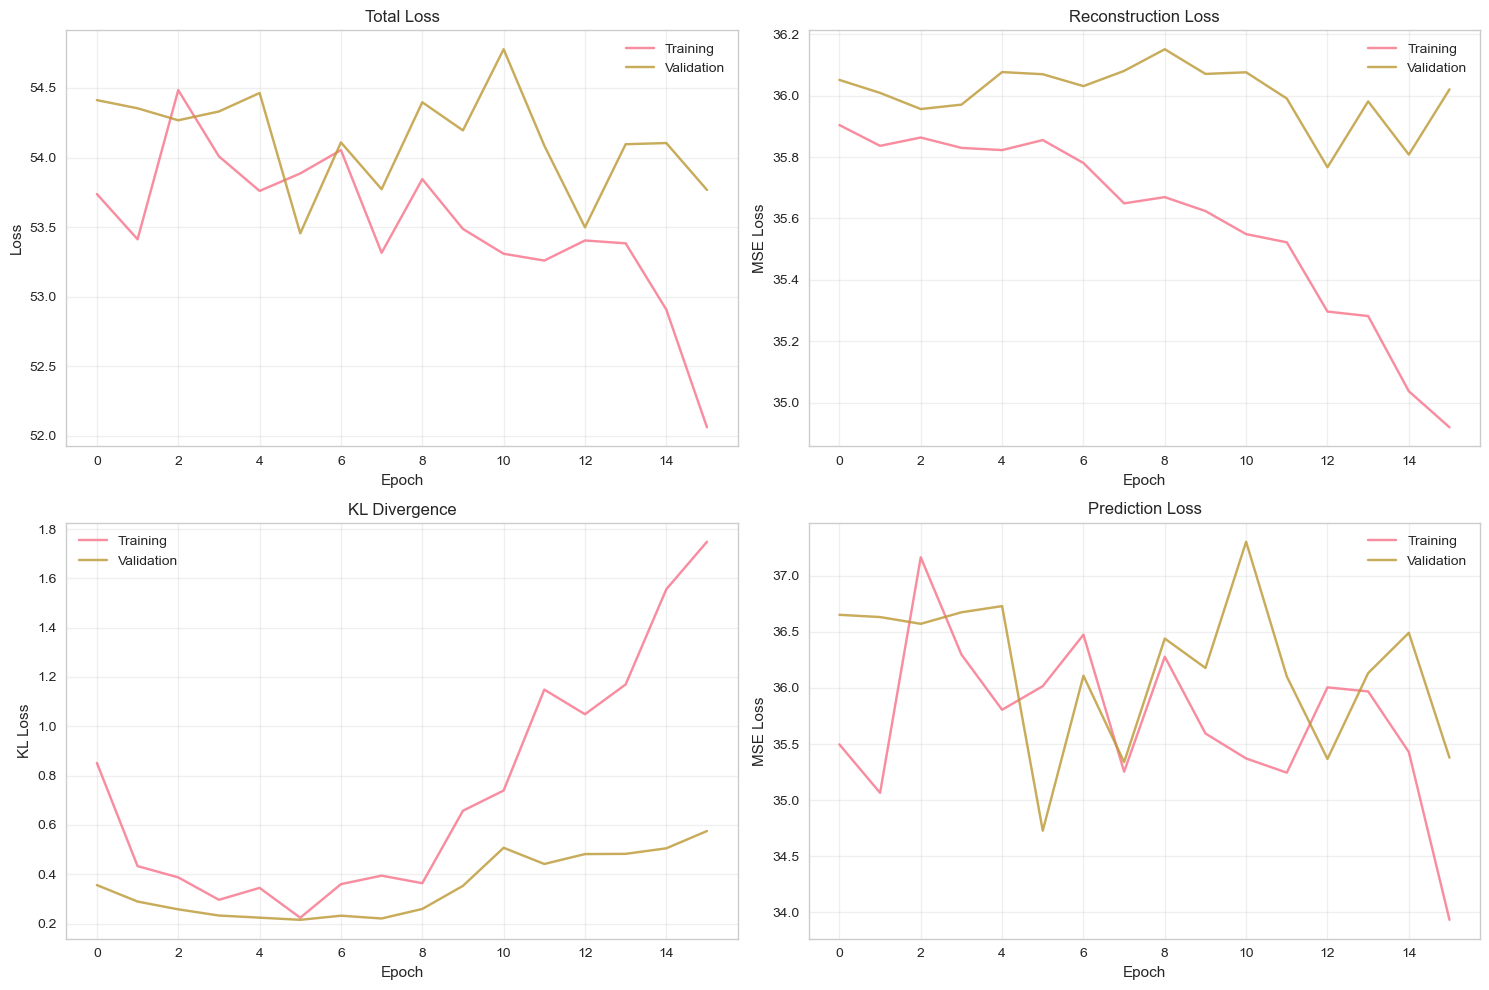

In [155]:
import time
from collections import defaultdict
import matplotlib.pyplot as plt

def create_data_loaders(train_data, val_data, batch_size=8):
    """Create data loaders for training"""
    
    print(f"=== CREATING DATA LOADERS ===")
    print(f"Batch size: {batch_size}")
    
    # Training data loader
    train_dataset = TensorDataset(
        train_data['neural'],
        train_data['behavioral'],
        train_data['timestamps']
    )
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # Validation data loader
    val_dataset = TensorDataset(
        val_data['neural'],
        val_data['behavioral'], 
        val_data['timestamps']
    )
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    print(f"Training batches: {len(train_loader)}")
    print(f"Validation batches: {len(val_loader)}")
    
    return train_loader, val_loader

def train_epoch(model, train_loader, optimizer, loss_fn, device, epoch):
    """Train for one epoch"""
    
    model.train()
    epoch_losses = defaultdict(list)
    
    for batch_idx, (neural_data, behavioral_data, timestamps) in enumerate(train_loader):
        # Move to device
        neural_data = neural_data.to(device)
        behavioral_data = behavioral_data.to(device)
        timestamps = timestamps.to(device)
        
        # Use first timepoint as initial observation
        initial_obs = neural_data[:, 0, :]  # (batch_size, 5)
        
        # Subsample timestamps for efficiency (every 10th point)
        subsample_factor = 10
        subsampled_timestamps = timestamps[:, ::subsample_factor]
        target_trajectory = neural_data[:, ::subsample_factor, :]
        
        try:
            # Forward pass
            optimizer.zero_grad()
            
            predicted_trajectory, z_mean, z_log_var = model(
                initial_obs,
                behavioral_data,
                subsampled_timestamps,
                return_trajectory=True
            )
            
            # Compute loss
            total_loss, loss_dict = loss_fn.total_loss(
                predicted_trajectory,
                target_trajectory,
                z_mean,
                z_log_var
            )
            
            # Backward pass
            total_loss.backward()
            
            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            # Record losses
            for key, value in loss_dict.items():
                epoch_losses[key].append(value)
                
            if batch_idx % 5 == 0:
                print(f"Epoch {epoch}, Batch {batch_idx}/{len(train_loader)}: "
                      f"Loss = {loss_dict['total']:.4f}")
                
        except Exception as e:
            print(f"Error in batch {batch_idx}: {e}")
            continue
    
    # Average losses
    avg_losses = {key: np.mean(values) for key, values in epoch_losses.items()}
    return avg_losses

def validate_epoch(model, val_loader, loss_fn, device):
    """Validate for one epoch"""
    
    model.eval()
    epoch_losses = defaultdict(list)
    
    with torch.no_grad():
        for batch_idx, (neural_data, behavioral_data, timestamps) in enumerate(val_loader):
            # Move to device
            neural_data = neural_data.to(device)
            behavioral_data = behavioral_data.to(device)
            timestamps = timestamps.to(device)
            
            # Use first timepoint as initial observation
            initial_obs = neural_data[:, 0, :]
            
            # Subsample timestamps
            subsample_factor = 10
            subsampled_timestamps = timestamps[:, ::subsample_factor]
            target_trajectory = neural_data[:, ::subsample_factor, :]
            
            try:
                # Forward pass
                predicted_trajectory, z_mean, z_log_var = model(
                    initial_obs,
                    behavioral_data,
                    subsampled_timestamps,
                    return_trajectory=True
                )
                
                # Compute loss
                total_loss, loss_dict = loss_fn.total_loss(
                    predicted_trajectory,
                    target_trajectory,
                    z_mean,
                    z_log_var
                )
                
                # Record losses
                for key, value in loss_dict.items():
                    epoch_losses[key].append(value)
                    
            except Exception as e:
                print(f"Validation error in batch {batch_idx}: {e}")
                continue
    
    # Average losses
    avg_losses = {key: np.mean(values) for key, values in epoch_losses.items()}
    return avg_losses

def train_neural_ode(model, train_loader, val_loader, loss_fn, optimizer, 
                    n_epochs=50, device='cpu'):
    """Complete training pipeline"""
    
    print(f"=== STARTING NEURAL ODE TRAINING ===")
    print(f"Device: {device}")
    print(f"Epochs: {n_epochs}")
    print(f"Optimizer: {type(optimizer).__name__}")
    
    # Move model to device
    model = model.to(device)
    
    # Training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_reconstruction': [],
        'val_reconstruction': [],
        'train_kl': [],
        'val_kl': [],
        'train_prediction': [],
        'val_prediction': []
    }
    
    best_val_loss = float('inf')
    patience = 10
    patience_counter = 0
    
    start_time = time.time()
    
    for epoch in range(n_epochs):
        epoch_start = time.time()
        
        # Training
        train_losses = train_epoch(model, train_loader, optimizer, loss_fn, device, epoch)
        
        # Validation
        val_losses = validate_epoch(model, val_loader, loss_fn, device)
        
        # Record history
        history['train_loss'].append(train_losses['total'])
        history['val_loss'].append(val_losses['total'])
        history['train_reconstruction'].append(train_losses['reconstruction'])
        history['val_reconstruction'].append(val_losses['reconstruction'])
        history['train_kl'].append(train_losses['kl_divergence'])
        history['val_kl'].append(val_losses['kl_divergence'])
        history['train_prediction'].append(train_losses['prediction'])
        history['val_prediction'].append(val_losses['prediction'])
        
        epoch_time = time.time() - epoch_start
        
        print(f"\nEpoch {epoch+1}/{n_epochs} completed in {epoch_time:.2f}s")
        print(f"Train Loss: {train_losses['total']:.4f} | Val Loss: {val_losses['total']:.4f}")
        print(f"Train Recon: {train_losses['reconstruction']:.4f} | Val Recon: {val_losses['reconstruction']:.4f}")
        print(f"Train KL: {train_losses['kl_divergence']:.4f} | Val KL: {val_losses['kl_divergence']:.4f}")
        print("-" * 60)
        
        # Early stopping
        if val_losses['total'] < best_val_loss:
            best_val_loss = val_losses['total']
            patience_counter = 0
            # Save best model
            torch.save(model.state_dict(), 'best_ofc_neural_ode.pth')
            print(f"💾 New best model saved! Val Loss: {best_val_loss:.4f}")
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f"⏰ Early stopping after {epoch+1} epochs")
            break
    
    total_time = time.time() - start_time
    print(f"\n=== TRAINING COMPLETE ===")
    print(f"Total time: {total_time:.2f}s")
    print(f"Best validation loss: {best_val_loss:.4f}")
    
    return history

def plot_training_history(history):
    """Plot training history"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Total loss
    axes[0, 0].plot(history['train_loss'], label='Training', alpha=0.8)
    axes[0, 0].plot(history['val_loss'], label='Validation', alpha=0.8)
    axes[0, 0].set_title('Total Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Reconstruction loss
    axes[0, 1].plot(history['train_reconstruction'], label='Training', alpha=0.8)
    axes[0, 1].plot(history['val_reconstruction'], label='Validation', alpha=0.8)
    axes[0, 1].set_title('Reconstruction Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('MSE Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # KL divergence
    axes[1, 0].plot(history['train_kl'], label='Training', alpha=0.8)
    axes[1, 0].plot(history['val_kl'], label='Validation', alpha=0.8)
    axes[1, 0].set_title('KL Divergence')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('KL Loss')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Prediction loss
    axes[1, 1].plot(history['train_prediction'], label='Training', alpha=0.8)
    axes[1, 1].plot(history['val_prediction'], label='Validation', alpha=0.8)
    axes[1, 1].set_title('Prediction Loss')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('MSE Loss')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Set up training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create data loaders
train_loader, val_loader = create_data_loaders(train_data, val_data, batch_size=8)

# Set up optimizer with learning rate scheduling
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# Start training
print("\n🚀 Starting Neural ODE training...")
history = train_neural_ode(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    n_epochs=30,  # Start with 30 epochs
    device=device
)

# Plot results
plot_training_history(history)